In [40]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
#from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from helper import get_confusion_matrix, model_results

plt.style.use('ggplot')

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

In [26]:
train_data = pd.read_csv("train_sampled.csv", index_col=0)

## Preparing the data for Bagging & Boosting

In [27]:
le =LabelEncoder()
serviceType =le.fit_transform(train_data['ServiceType'])

train_nonlinear= train_data.copy()
train_nonlinear['ServiceType'] = serviceType

features = train_nonlinear.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train_nonlinear['PotentialFraud']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [33]:
gbc= ensemble.GradientBoostingClassifier()

np.random.seed(5)
grid_boost_para = [{
    "n_estimators": [110, 120, 130],
    "learning_rate":np.linspace(0.1, 1, 20),
    "min_samples_split": range(1, 10),
    "min_samples_leaf":range(1,10),
    "max_depth": [5, 30, 5]
}]

grid_boost = RandomizedSearchCV(gbc, grid_boost_para, scoring ='accuracy',cv=5)
# grid_boost.fit(X_train, y_train)

In [34]:
grid_boost.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions=[{'learning_rate': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                                         'max_depth': [5, 30, 5],
                                         'min_samples_leaf': range(1, 10),
                                         'min_samples_split': range(1, 10),
                                         'n_estimators': [110, 120, 130]}],
                   scoring='accuracy')

In [35]:
print(grid_boost.best_params_)
print(grid_boost.best_score_)

{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 30, 'learning_rate': 0.43157894736842106}
0.9801182139624005


In [36]:
model_results(X_train, y_train, X_test, y_test, grid_boost, show=True)

The Model Results for  RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions=[{'learning_rate': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                                         'max_depth': [5, 30, 5],
                                         'min_samples_leaf': range(1, 10),
                                         'min_samples_split': range(1, 10),
                                         'n_estimators': [110, 120, 130]}],
                   scoring='accuracy')
************************************************************
Train Accuracy is equal to 1.000
Test Accuracy is equal to 0.986
The Precision score is 0.972
The Average Precision score is 0.972
The Recall score is 1.000
The F1 score is 0.986
The AUC/ROC 

[1.0, 0.9857288481141692, 0.9722497522299306, 1.0]

Text(0, 0.5, 'Features')

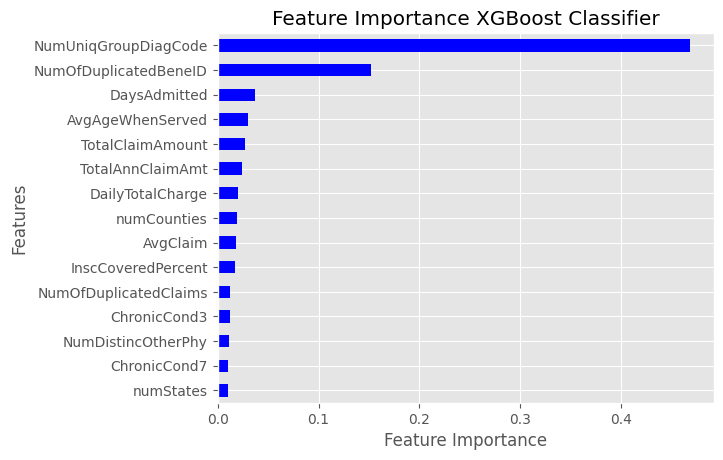

In [38]:
#Feature importance
sorted_importance = sorted(zip(features.columns, grid_boost.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)[:15]
sorted_importance.sort(key= lambda t : t[1])

a, b = zip(*sorted_importance) # this splits the list of tuples into two lists

pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.barh(x='feature_name',
                                                                 y='importance_score', 
                                                                 color='blue',
                                                                 legend=None)
plt.title('Feature Importance XGBoost Classifier')
plt.xlabel("Feature Importance")
plt.ylabel("Features")

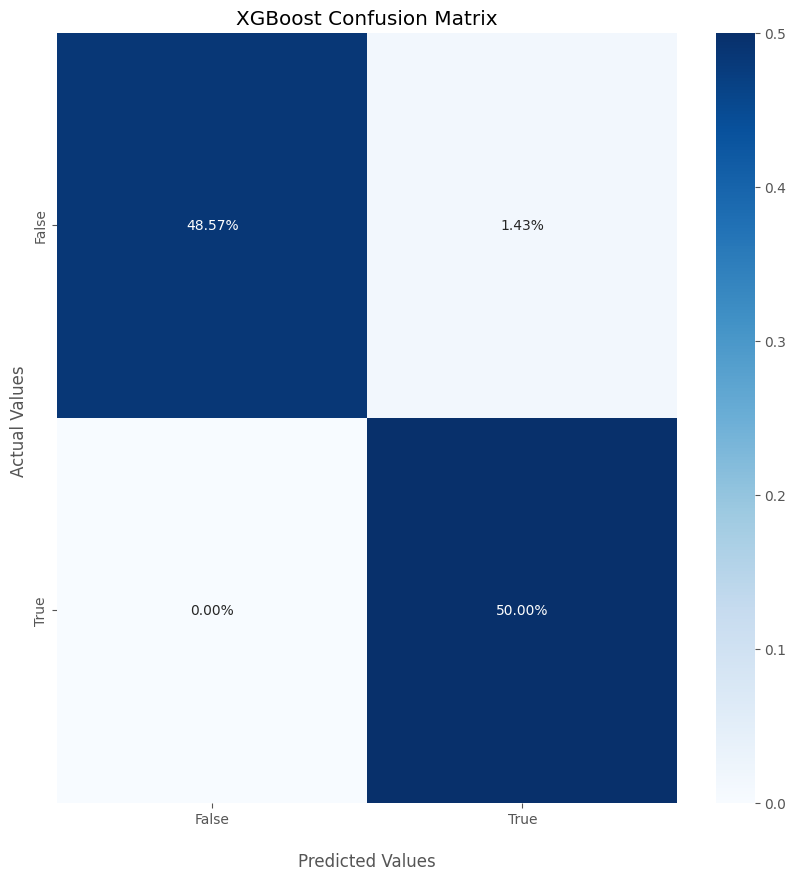

In [39]:
cm = get_confusion_matrix(grid_boost, X_test, y_test)

labels = ['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('XGBoost Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Unary Classification

* Perform a unary classification to check the accuracy of individual features

In [41]:
forest_trial= ensemble.RandomForestClassifier(criterion='gini', max_depth=29, n_estimators=10)
le = LabelEncoder()

serviceType =le.fit_transform(train_data['ServiceType'])
train= train_data.copy()
train['ServiceType'] = serviceType

features = train.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train['PotentialFraud']

In [42]:
acc= {}

for i in range(len(features.columns)):
    forest_trial.fit(pd.DataFrame(features.iloc[:,i]), target)
    acc[features.columns[i]] = forest_trial.score(pd.DataFrame(features.iloc[:,i]), target)

<AxesSubplot:ylabel='features'>

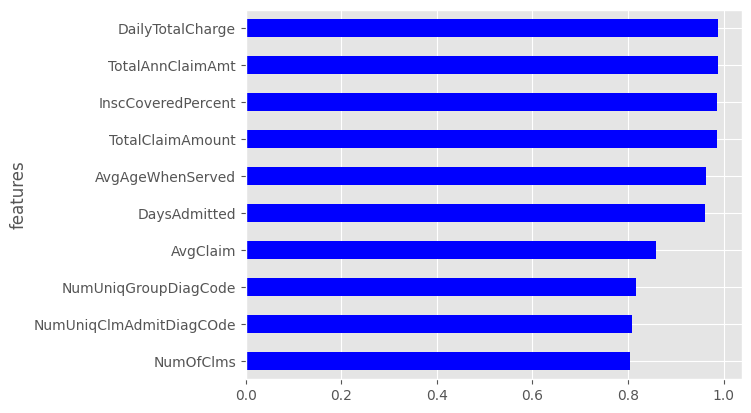

In [43]:
a = sorted(acc.items(), key= lambda x : x[1],reverse=True)[:10]
a.sort(key = lambda x : x[1])

c, d  = zip(*a)

pd.DataFrame({'features':c, 'accuracy': d}).plot(kind='barh', x='features', y='accuracy', color="blue", legend=False)